# Notebook: OHC
**Version**: v1.2-beta 

**Last update**: 2025-09-15

**Authors**: INGV

# Ocean Heat Content (OHC) as an Ocean Monitoring Indicator

The **Ocean Heat Content (OHC)** is considered an important **Ocean Monitoring Indicator** of ocean warming due to climate change.  
With about **90% of the excess heat** accumulated in the Earth system deposited in the world’s ocean, the **Earth Energy Imbalance** causes rising ocean temperatures and increasing OHC.  

---

## OHC in the Mediterranean Sea

The **Mediterranean Sea** is the ocean region that shows the **highest warming** (Fig. 22), thus it is extremely important to have a rapid and efficient OHC assessment.  

The **Copernicus Marine Service** also provides in its **Ocean Monitoring Indicators catalogue** the **Mediterranean OHC Anomaly (0–700 m)** time series (Fig. 23) and trend from **Reanalysis & Multi-Observations Reprocessing**, but without a systematic yearly update.  

The **Blue Cloud 2026 proposal** of OHC indicator would provide an **operational workflow** that allows rapid Mediterranean OHC estimation from multiple data sources.  
Moreover, the use of the **Workbench 1 EOVs dataset**, which integrates data from the four main BDIs, would maximize data spatial and temporal coverage, reducing the associated product uncertainty.  

---

## Mathematical Definition of OHC

OHC has been defined within the **Copernicus Marine Service** (von Schuckmann et al., 2016) as the **deviation from a reference period** and is closely proportional to the average temperature change in a specific ocean layer (usually from the surface to 700 m or 2000 m depth):
$$
OHC = \rho_0 \, C_p \int_{z_1}^{z_2} (T_i - T) \, dz
$$

Where:  

- $\rho_0 = 1030 \, \text{kg} \, \text{m}^{-3}$ → reference density  
- $C_p = 3980 \, \text{J} \, \text{kg}^{-1} \, °C^{-1}$ → specific heat capacity  
- $T_i$ → in-situ temperature  
- $T$ → reference temperature  
- $z_1, z_2$ → depth limits of integration  


---

## SeaDataCloud OHC Product

Within the **SeaDataCloud project**, a Mediterranean OHC product was delivered (Simoncelli et al., 2020; 2021).  

- Input data from **SeaDataNet** and **CMS-CORA (version 5.2)** were integrated and provided to the **DIVAnd tool** to obtain temperature gridded fields (sliding decades) between the sea surface and 2000 m of depth.  
- From these gridded fields, **OHC anomaly time series and trends** were computed in the layers 0–700 m (Fig. 24) and 0–2000 m.  

The workflow implemented in the **SeaDataCloud** project has been deployed in the **MEI VLab**, and developments are ongoing to use the **Beacon monolithic instances** as input data, extending the time coverage closer to the present.


# Ocean Heat Content computation

This notebook serves for the Ocean Heat Content computation:
1. horizontal resolution = 0.125 sexagesimal degrees;
2. MED box: lon = [-5.625 36.5] degrees E, lat = [30 46] degrees N;
4. Inputed 1955-2017 temperature sliding decades annual analysis;
6. Mask “gebco_2019_mask_1_8_edited_final.nc” edited opening and closing numerous zones and with removed less than 3 points connected components (WOA13 and WOA18 depth levels versions);
16. Ocean heat content plots 0-2000m, computation and save in netCDF format for publication.

## Packages and Libraries

In [1]:
########################################################################
# IMPORTING LIBRARIES AND PACKAGES
########################################################################
import os
from collections import OrderedDict
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy.ma as ma
import requests
import json
import xarray as xr
import datetime
import ipywidgets as widgets
from ipywidgets import widgets, interact, interactive, FloatRangeSlider, IntRangeSlider, IntSlider, fixed
from IPython.display import display, Javascript
import pandas as pds

## Metadata

In [2]:
# Metadata information
project = "BlueCloud26"
institution_urn = "SDN:EDMO::251"
in_variable_name = "Ocean_Heat_Content"
production = ("INGV oceanography group. Emails: enrico.baglione@ingv.it; "
              "simona.simoncelli@ingv.it; paolo.oliveri@ingv.it")
author_email = [
    "Enrico Baglione <enrico.baglione@ingv.it>",
    "Simona Simoncelli <simona.simoncelli@ingv.it>",
    "Paolo Oliveri <paolo.oliveri@ingv.it>"
]
source = "observational data from SeaDataNet, CORA 5.2"
comment = "Duplicates removal and QC applied to the integrated dataset"
search_keywords_urn = "SDN:P02::TEMP"
area_keywords_urn = "SDN:C19::3_1"
product_version = "1.0"
product_code = "SDC_MED_DP2"
bathymetry_source = ("The GEBCO Digital Atlas published by the British Oceanographic "
                     "Data Centre on behalf of IOC and IHO, 2003")
standard_name = "integral_wrt_depth_of_sea_water_temperature_expressed_as_heat_content"
long_name = "Area Averaged Ocean Heat Content Anomaly"
units = "J m-2"
abstract_name = ("SDC_MED_DP2 product contains Temperature annual sliding "
                 "climatological field and Area Averaged Ocean Heat Content Anomaly. "
                 "The climatological field has been computed from SeaDataNet infrastructure "
                 "and CORA (Coriolis Ocean dataset for ReAnalysis) integrated dataset "
                 "using the DIVAnd (Data-Interpolating Variational Analysis in n dimensions) "
                 "version 2.6.1")
acknowledgement = "____________________"
documentation = "_____________________"
doi = "__________________"

## Data reading
Observations are read from SDC V1 and CORA V52 vertically interpolated to WOA 2018 depth layers dataset.

In [3]:
####################################################################
print("Please give base data directory...")

# Read the base directory input
#base_dir = input()
#base_dir = '/home/jovyan/blue-cloud-dataspace/MEI/INGV/INPUT/'

# File paths
mask_file_woa13 = "blue-cloud-dataspace/MEI/INGV/INPUT/BATHYMETRY/gebco_2019_mask_1_8_edited_final_woa13.nc"
mask_file = "blue-cloud-dataspace/MEI/INGV/INPUT/BATHYMETRY/gebco_2019_mask_1_8_edited_final.nc"
experiment = "WP"

'''
# Output directory path
out_dir = os.path.join(base_dir, "Output", "VRE", "Ocean_Heat_Content")

# Check if directory exists, otherwise create it
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)
    print(f"Creating directory {out_dir}") = 
'''
base_dir = 'blue-cloud-dataspace/MEI/INGV/INPUT/'
out_dir = 'blue-cloud-dataspace/MEI/INGV/INPUT/'

Please give base data directory...


In [4]:
##### Defining the Output Path
OUTPUT_PATH = 'blue-cloud-dataspace/MEI/OceanHeatContent/'
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [5]:
# Define the range of years
years = np.arange(1960, 2015)

# Climatology directory
#climatology_dir = os.path.join(out_dir, "annual")
climatology_dir = os.path.join(out_dir, "CLIMATOLOGY")

'''
# Check if the climatology directory exists, otherwise create it
if not os.path.isdir(climatology_dir):
    os.makedirs(climatology_dir)
    print(f"Creating directory {climatology_dir}")
'''

'\n# Check if the climatology directory exists, otherwise create it\nif not os.path.isdir(climatology_dir):\n    os.makedirs(climatology_dir)\n    print(f"Creating directory {climatology_dir}")\n'

In [6]:
# Background reference file
temperature_file = f"{climatology_dir}/Temperature_sliding_climatology_{experiment}.nc"

# Output file
out_file = f"{climatology_dir}/{in_variable_name}_{experiment}.nc"

In [7]:
# Global attributes for NetCDF file (converted from Julia OrderedDict to Python OrderedDict)
ncglobalattrib = OrderedDict([
    ("project", project),
    ("institution", "Istituto Nazionale di Geofisica e Vulcanologia – Sede di Bologna"),
    ("institution_urn", institution_urn),
    ("production", production),
    ("Author_e-mail", author_email),
    ("source", source),
    ("comment", comment),
    ("search_keywords", "Temperature of the water column"),
    ("search_keywords_urn", search_keywords_urn),
    ("area_keywords", "Mediterranean Sea"),
    ("area_keywords_urn", area_keywords_urn),
    ("product_code", product_code),
    ("product_version", product_version),
    ("bathymetry_source", bathymetry_source),
    ("abstract", abstract_name),
    ("acknowledgement", acknowledgement),
    ("documentation", documentation),
    ("doi", doi),
    ("data_access", "____________________________"),
    ("WEB_visualisation", "_____________________________")
])

## Grid selection

In [8]:
# resolution (the resolution is only used for eventual DIVAnd analyses)
dx = dy = 0.125  # 1/8 degree

# vectors defining the longitude and latitudes grids
# Here longitude and latitude correspond to the Mediterranean Sea
lonr = np.arange(-5.625, 36.5 + dx, dx)
latr = np.arange(30.0, 46.0 + dy, dy)

# WOA 2018 102 depth range levels (cut at 2500m)
depthr = np.array([0., 5., 10., 15., 20., 25., 30., 35., 40., 45.,
                   50., 55., 60., 65., 70., 75., 80., 85., 90., 95.,
                   100., 125., 150., 175., 200., 225., 250., 275., 300., 325.,
                   350., 375., 400., 425., 450., 475., 500., 550., 600., 650.,
                   700., 750., 800., 850., 900., 950., 1000., 1050., 1100., 1150.,
                   1200., 1250., 1300., 1350., 1400., 1450., 1500., 1550., 1600., 1650.,
                   1700., 1750., 1800., 1850., 1900., 1950., 2000.])

# Degree to meter conversion multiplier
deg_multiplier = 111319.5

#### In the widgets below, you should select your preferred filters and press "Execute all cells" to run it.

In [9]:
# Interactive Function
def analyze_data(parameter, lon_range, lat_range, depth_range, year_range):
    
    

    # Trova il valore più vicino nell'array 'depthr'
    depth_closer_value = depthr[(np.abs(depthr - depth_range)).argmin()]

    print(f"Il valore dato è: {depth_range}")
    print(f"Il valore più vicino in 'depthr' è: {depth_closer_value}")

    
    minlon, maxlon = lon_range
    minlat, maxlat = lat_range
    mindepth, maxdepth = 0., depth_closer_value
    start_year, end_year = year_range
    
    # Filter parameters based on selected ranges
    lon_filter = (lonr >= minlon) & (lonr <= maxlon)
    lat_filter = (latr >= minlat) & (latr <= maxlat)
    depth_filter = (depthr >= mindepth) & (depthr <= maxdepth)
    year_filter = (years >= start_year) & (years <= end_year)
    
    filtered_lon = lonr[lon_filter]
    filtered_lat = latr[lat_filter]
    filtered_depth = depthr[depth_filter]
    filtered_years = years[year_filter]
    
    # Here you could include additional analysis using filtered parameters

# Widgets with increased width



lon_slider = FloatRangeSlider(
    value=[lonr.min(), lonr.max()], 
    min=lonr.min(), 
    max=lonr.max(), 
    step=dx, 
    description='Longitude Range', 
    layout=widgets.Layout(width='400px'),
    style={'description_width': 'auto'}
)

lat_slider = FloatRangeSlider(
    value=[latr.min(), latr.max()], 
    min=latr.min(), 
    max=latr.max(), 
    step=dy, 
    description='Latitude Range', 
    layout=widgets.Layout(width='400px'),
    style={'description_width': 'auto'}
)


'''
depth_slider = FloatRangeSlider(
    value=[depthr.min(), depthr.max()], 
    min=depthr.min(), 
    max=depthr.max(), 
    step=10, 
    description='Depth Range (m)', 
    layout=widgets.Layout(width='400px'),
    style={'description_width': 'auto'}
)
'''

# Assicurati di avere 'import ipywidgets as widgets' all'inizio del tuo script

depth_slider = widgets.FloatSlider(
    value=depthr.max(),
    min=0,
    max=depthr.max(),
    step=10,
    description='Profondità Massima (m)',
    layout=widgets.Layout(width='400px'),
    style={'description_width': 'auto'}
)


year_slider = IntRangeSlider(
    value=[years.min(), years.max()], 
    min=years.min(), 
    max=years.max(), 
    step=1, 
    description='Time Range (y)', 
    layout=widgets.Layout(width='400px'),
    style={'description_width': 'auto'}
)



# Combine widgets into an interactive dashboard
w = interactive(analyze_data, 
                parameter=fixed([lonr, latr, depthr]), 
                lon_range=lon_slider, 
                lat_range=lat_slider, 
                depth_range=depth_slider,
                #start_year=start_year_picker, 
                #end_year=end_year_picker
                year_range=year_slider)

# Display the interactive widget
display(w)

# Button to execute all cells
def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

button = widgets.Button(description="Execute All Cells")
button.on_click(run_all)
display(button)

interactive(children=(FloatRangeSlider(value=(-5.625, 36.5), description='Longitude Range', layout=Layout(widt…

Button(description='Execute All Cells', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Trova il valore più vicino nell'array 'depthr'
depth_closer_value = depthr[(np.abs(depthr - depth_slider.value)).argmin()]

print(f"Il valore dato è: {depth_slider.value}")
print(f"Il valore più vicino in 'depthr' è: {depth_closer_value}")

# Extracting the widget values
lon_min, lon_max = lon_slider.value
lat_min, lat_max = lat_slider.value
depth_min, depth_max = 0, depth_closer_value
t_min, t_max = year_slider.value


print("Selected Longitude Range:", lon_min, lon_max)
print("Selected Latitude Range:", lat_min, lat_max)
print("Selected Depth Range:", depth_min, depth_max)
print("Selected Year Range:", t_min, t_max)

Il valore dato è: 1080.0
Il valore più vicino in 'depthr' è: 1100.0
Selected Longitude Range: -1.625 28.125
Selected Latitude Range: 31.75 44.875
Selected Depth Range: 0 1100.0
Selected Year Range: 1960 2014


## Load the mask
It is used to delimit the variational analysis. External file provided.

In [11]:
# Open the mask file in read mode
mask_data = Dataset(mask_file, "r")

# Extract longitude, latitude, and depth from the mask file
lon_mask = mask_data["lon"][:]
lat_mask = mask_data["lat"][:]
depth_mask = mask_data["depth"][:]

# Convert mask data to boolean and handle 3D arrays
mask = mask_data["mask"][:,:,:].astype(bool)

# Extract delta_lon, delta_lat, delta_depth (all 3D arrays)
delta_lon = mask_data["delta_lon"][:,:,:]
delta_lat = mask_data["delta_lat"][:,:,:]
delta_depth = mask_data["delta_depth"][:,:,:]

# Close the mask file
mask_data.close()

# Permute dimensions to match Julia's potential behavior (if necessary)
mask = np.transpose(mask, (2, 1, 0))

# Extract delta_lon, delta_lat, delta_depth (all 3D arrays)
delta_lon = np.transpose(delta_lon, (2, 1, 0))
delta_lat = np.transpose(delta_lat, (2, 1, 0))
delta_depth = np.transpose(delta_depth, (2, 1, 0))

# Show the size of the mask
print("Size of mask:", mask.shape)
print("Size of delta_lon:", delta_lon.shape)
print("Size of delta_lat:", delta_lon.shape)
print("Size of delta_depth:", delta_lon.shape)

Size of mask: (367, 129, 92)
Size of delta_lon: (367, 129, 92)
Size of delta_lat: (367, 129, 92)
Size of delta_depth: (367, 129, 92)


### Cut mask at seleted horizontal lat-lon-depth box

In [12]:
# GENERATE THE MASK FOR VARIABLE BASIN
# Find indices where lon_mask, lat_mask, and depth_mask match the lonr, latr, and depthr ranges

print(depth_max)
############################################
#      LONGITUDE
############################################
#lon_min, lon_max = lonr[0], lonr[-1]
start_lon_mask_index = np.where(lon_mask == lon_min)[0][0]
end_lon_mask_index = np.where(lon_mask == lon_max)[0][0]

############################################
#      LATITUDE
############################################
#lat_min, lat_max = latr[0], latr[-1]
start_lat_mask_index = np.where(lat_mask == lat_min)[0][0]
end_lat_mask_index = np.where(lat_mask == lat_max)[0][0]

############################################
#      DEPTH
############################################
start_depth_mask_index = np.where(depth_mask == depth_min)[0][0]
end_depth_mask_index = np.where(depth_mask == depth_max)[0][0]


# Print the sizes of lon_mask, lat_mask, and depth_mask
print("Size of lon_mask:", lon_mask.shape)
print("Size of lat_mask:", lat_mask.shape)
print("Size of depth_mask:", depth_mask.shape)

# Slice the masks and deltas based on the computed indices
lon_mask = lon_mask[start_lon_mask_index:end_lon_mask_index+1]
lat_mask = lat_mask[start_lat_mask_index:end_lat_mask_index+1]
depth_mask = depth_mask[start_depth_mask_index:end_depth_mask_index+1]

mask = mask[start_lon_mask_index:end_lon_mask_index+1, 
            start_lat_mask_index:end_lat_mask_index+1, 
            start_depth_mask_index:end_depth_mask_index+1]

delta_lon = delta_lon[start_lon_mask_index:end_lon_mask_index+1, 
                      start_lat_mask_index:end_lat_mask_index+1, 
                      start_depth_mask_index:end_depth_mask_index+1]

delta_lat = delta_lat[start_lon_mask_index:end_lon_mask_index+1, 
                      start_lat_mask_index:end_lat_mask_index+1, 
                      start_depth_mask_index:end_depth_mask_index+1]

delta_depth = delta_depth[start_lon_mask_index:end_lon_mask_index+1, 
                          start_lat_mask_index:end_lat_mask_index+1, 
                          start_depth_mask_index:end_depth_mask_index+1]

# Print the size of the mask
print("Size of mask:", mask.shape)

1100.0
Size of lon_mask: (367,)
Size of lat_mask: (129,)
Size of depth_mask: (92,)
Size of mask: (239, 106, 49)


In [13]:
############################################################################
# Defining the suffix for the output files
############################################################################
suffix = str(int(lon_min)) + '_' + str(int(lon_max)) + '_'  \
         + str(int(lat_min)) + '_' + str(int(lat_max)) + '_' \
         + str(int(depth_min)) + '_' + str(int(depth_max))

print('SUFFIX: ', suffix)

SUFFIX:  -1_28_31_44_0_1100


In [14]:
# extract lon and lat values of the grid interested by the domain
print('length before extraction ', len(lonr))
lonr = lonr[(lonr >= lon_min) & (lonr <= lon_max)]
latr = latr[(latr >= lat_min) & (latr <= lat_max)]
print('length after extraction ', len(lonr))

length before extraction  338
length after extraction  239


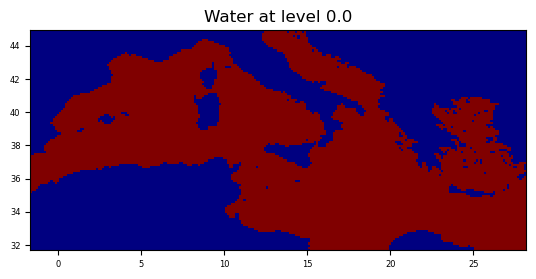

In [15]:
# Loop over depth levels (here you only loop for level 1, modify if you need more levels)
for level in range(1):  # You can change this to len(depth_mask) if needed
    plt.figure()
    ax = plt.gca()

    # Set the aspect ratio of the plot based on the latitude
    ax.set_aspect(1 / np.cos(np.mean(ax.get_ylim()) * np.pi / 180))

    # Adjust tick parameters for readability
    ax.tick_params(axis='both', labelsize=6)

    # Plot the mask data for the specific depth level
    #plt.pcolor(lon_mask, lat_mask, mask[:, :, level].astype(float).T, cmap='jet')
    plt.pcolor(lon_mask, lat_mask, mask[:, :, level].astype(float).T, cmap='jet', shading='nearest')  # Change shading

    # Add a title showing the depth level
    plt.title(f"Water at level {depthr[level]}")

    # Show the plot
    plt.show()

## Empty mask depth levels cut

In [16]:
# Adjust mask and delta arrays by slicing them along the depth dimension
mask = mask[:, :, :len(depth_mask)]
delta_lon = delta_lon[:, :, :len(depth_mask)]
delta_lat = delta_lat[:, :, :len(depth_mask)]
delta_depth = delta_depth[:, :, :len(depth_mask)]
depthr = depthr[:len(depth_mask)]

# Display the sizes of the arrays (equivalent to @show size in Julia)
print("Size of mask:", mask.shape)
print("Size of delta_lon:", delta_lon.shape)
print("Size of delta_lat:", delta_lat.shape)
print("Size of delta_depth:", delta_depth.shape)
print("Size of depthr:", len(depthr))

print(depthr[0])
print(depthr[-1])
print(delta_lon[0])
print(delta_lon[-1])

Size of mask: (239, 106, 49)
Size of delta_lon: (239, 106, 49)
Size of delta_lat: (239, 106, 49)
Size of delta_depth: (239, 106, 49)
Size of depthr: 49
0.0
1100.0
[[11819.373 11819.373 11819.373 ... 11819.373 11819.373 11819.373]
 [11803.389 11803.389 11803.389 ... 11803.389 11803.389 11803.389]
 [11787.348 11787.348 11787.348 ... 11787.348 11787.348 11787.348]
 ...
 [ 9892.465  9892.465  9892.465 ...  9892.465  9892.465  9892.465]
 [ 9871.141  9871.141  9871.141 ...  9871.141  9871.141  9871.141]
 [ 9849.769  9849.769  9849.769 ...  9849.769  9849.769  9849.769]]
[[11819.373 11819.373 11819.373 ... 11819.373 11819.373 11819.373]
 [11803.389 11803.389 11803.389 ... 11803.389 11803.389 11803.389]
 [11787.348 11787.348 11787.348 ... 11787.348 11787.348 11787.348]
 ...
 [ 9892.465  9892.465  9892.465 ...  9892.465  9892.465  9892.465]
 [ 9871.141  9871.141  9871.141 ...  9871.141  9871.141  9871.141]
 [ 9849.769  9849.769  9849.769 ...  9849.769  9849.769  9849.769]]


## Load Temperature file

In [17]:
# 2024/09/09
# Open the temperature dataset file
print(os.getcwd())
temperature_file = 'blue-cloud-dataspace/MEI/INGV/INPUT/CLIMATOLOGY/Temperature_sliding_climatology_WP.nc'
temperature_data = nc.Dataset(temperature_file, "r")

# Extract time and climatology_bounds
time = temperature_data["time"][:]
climatology_bounds = temperature_data["climatology_bounds"][:]

##########################################################################################
# 2024/07/30 update the temperature array as it has 4 dimensions (time, depth, lat, lon)
##########################################################################################
temperature = temperature_data["Temperature"][:]

###################################################
# REPLACING INFINITE VALUE WITH Nan

# Replace 9.96921e+36 with NaN
#temperature = np.array(temperature)  # Ensure it's a numpy array
#temperature[temperature == 9.96921e+36] = np.nan

###################################################
# REPLACING 9.96921e+36 WITH MASKED VALUE

# Create a masked array where 9.96921e+36 is treated as missing (masked)
#temperature_masked = np.ma.masked_values(temperature, 9.96921e+36)

# Printing minimum and maximum temperature values
print(f"Temperature profile min: {np.min(temperature)}")
print(f"Temperature profile max: {np.max(temperature)}")

# Show the size of the temperature array
print("Size of temperature array:", temperature.shape)

# rearranges the axes of the temperature
temperature = np.transpose(temperature, (3, 2, 1, 0))

# Show the size of the temperature array
print("Size of temperature array:", temperature.shape)

print('PUNTO ', temperature[99,99,1,3])

print("PUNTI DI INVERSIONE")
print(start_lon_mask_index,end_lon_mask_index,\
                           start_lat_mask_index, end_lat_mask_index,\
                           start_depth_mask_index, end_depth_mask_index)

# Slice the temperature array according to mask indices, including the last element of each dimension
temperature = temperature[start_lon_mask_index:end_lon_mask_index + 1,
                           start_lat_mask_index:end_lat_mask_index + 1,
                           start_depth_mask_index:end_depth_mask_index + 1, :]

# Printing minimum and maximum temperature values
print(f"Temperature profile min: {np.min(temperature)}")
print(f"Temperature profile max: {np.max(temperature)}")


# Close the temperature data file
temperature_data.close()

# Show the size of the sliced temperature array
print("Size of sliced temperature array:", temperature.shape)


# Target years to find in 'years'
target_years = np.array([1960, 1970, 1980, 1990, 2000, 2010])


# Find the indices in 'years' where the values match 'target_years'
time_indices = np.array([np.where(years == year)[0][0] if year in years else None for year in target_years])

print(time_indices)

# Calculate temperature reference by taking the mean over time indices
temperature_reference = np.expand_dims(np.nanmean(temperature[:, :, :, time_indices], axis=3), axis=3)


# Assuming 'temperature' is a NumPy array and 'time_indices' is a list or array of indices
temperature_filtered = np.ma.masked_array(temperature[:, :, :, time_indices], np.isnan(temperature[:, :, :, time_indices]))


# Display the size of temperature reference
print("Size of temperature reference array:", temperature_reference.shape)


# Show min and max temperature values of the sliced array
print(f"Temperature profile min: {np.ma.min(temperature)}")
print(f"Temperature profile max: {np.ma.max(temperature)}")

c:\Users\ousse\OHC_Repo
Temperature profile min: 4.442964553833008
Temperature profile max: 34.7874755859375
Size of temperature array: (55, 67, 129, 367)
Size of temperature array: (367, 129, 67, 55)
PUNTO  --
PUNTI DI INVERSIONE
61 299 14 119 0 48
Temperature profile min: 9.97671890258789
Temperature profile max: 34.7874755859375
Size of sliced temperature array: (239, 106, 49, 55)
[ 0 10 20 30 40 50]
Size of temperature reference array: (239, 106, 49, 1)
Temperature profile min: 9.97671890258789
Temperature profile max: 34.7874755859375


### CUTTING THE RIGHT TIME WINDOW

In [18]:
# Assuming 'years' is the array corresponding to the time axis of 'temperature'
# For example: years = np.arange(1955, 2018)

# 1. Find the indices of the years that are within the selected range [t_min, t_max]
year_indices = np.where((years >= t_min) & (years <= t_max))[0]

print(f"Filtering temperature array for years between {t_min} and {t_max}.")
print(f"Original number of years: {temperature.shape[3]}")

# 2. Use these indices to slice the temperature array along the time axis (the last axis)
temperature = temperature[:, :, :, year_indices]

# (Optional but recommended) Update the 'years' array as well to keep it consistent
years = years[year_indices]

time = time[year_indices]

print(f"New number of years: {temperature.shape[3]}")
print(f"New number of years: {len(time)}")
print("Size of the newly filtered temperature array:", temperature.shape)

Filtering temperature array for years between 1960 and 2014.
Original number of years: 55
New number of years: 55
New number of years: 55
Size of the newly filtered temperature array: (239, 106, 49, 55)


### Some Example Plots

-1.625 31.75


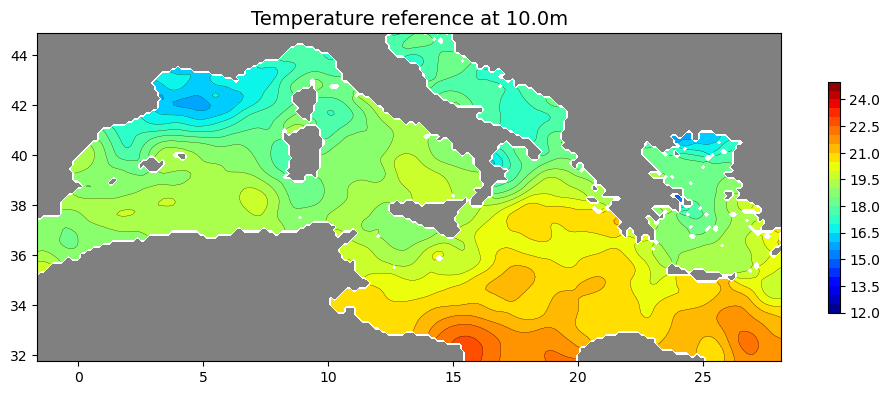

In [19]:
# Assuming lon_mask, lat_mask, mask, lonr, latr, temperature_reference, depthr, and levels are numpy arrays
print(lon_mask[0], lat_mask[0])
for level in range(2, 3):  # Equivalent to `3:3` in Julia (single iteration for level=3)
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    
    # Set aspect ratio
    ax.set_aspect(1 / np.cos(np.mean(ax.get_ylim()) * np.pi / 180))
    ax.tick_params(axis='both', labelsize=10)
    
    # Masking and contour plotting
    plt.contourf(lon_mask, lat_mask, np.transpose(mask[:, :, level]), levels=[-1e5, 0], colors=[(.5, .5, .5)])    
    
    plt.contour(lon_mask, lat_mask, np.transpose(np.nan_to_num(temperature_reference[:, :, level, 0], nan=np.nan)),
                levels=np.arange(12, 25.5, 0.5), colors='k', linewidths=0.2)
    
    # Temperature reference with colormap
    cmap = plt.get_cmap('jet')
    
    plt.contourf(lon_mask, lat_mask, np.transpose(np.nan_to_num(temperature_reference[:, :, level, 0], nan=np.nan)),
                 levels=np.arange(12, 25.5, 0.5), cmap=cmap)
    
    # Title and colorbar
    plt.title(f"Temperature reference at {depthr[level]}m", fontsize=14)
    cbar = plt.colorbar(orientation="vertical", shrink=0.5)
    cbar.ax.tick_params(labelsize=10)
    
    plt.show()

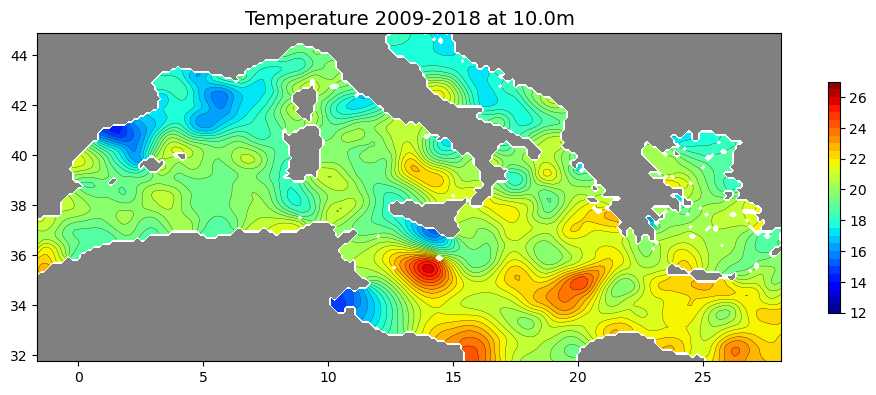

In [20]:
# Assuming lon_mask, lat_mask, mask, lonr, latr, temperature, temperature_reference, depthr, and years are numpy arrays

# First Loop
for level in range(2, 3):  # Equivalent to `3:3` in Julia
    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    # Set aspect ratio
    ax.set_aspect(1 / np.cos(np.mean(ax.get_ylim()) * np.pi / 180))
    ax.tick_params(axis='both', labelsize=10)

    # Masking and contour plotting
    plt.contourf(lon_mask, lat_mask, np.transpose(mask[:, :, level]), levels=[-1e5, 0], colors=[(.5, .5, .5)])
    
    # Contour for temperature
    
    plt.contour(lon_mask, lat_mask, np.transpose(np.nan_to_num(temperature[:, :, level, -1], nan=np.nan)),
                levels=np.arange(12, 27.5, 0.5), colors='k', linewidths=0.2)
    
    # Contourf with colormap
    cmap = plt.get_cmap('jet')
    
   
    plt.contourf(lon_mask, lat_mask, np.transpose(np.nan_to_num(temperature[:, :, level, -1], nan=np.nan)),
                 levels=np.arange(12, 27.5, 0.5), cmap=cmap)
    
    # Title and colorbar
    plt.title(f"Temperature 2009-2018 at {depthr[level]}m", fontsize=14)
    cbar = plt.colorbar(orientation="vertical", shrink=0.5)
    cbar.ax.tick_params(labelsize=10)

    plt.show()

### Hoev-Moller Plot for the Average Temperature

<>:33: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\c'
C:\Users\ousse\AppData\Local\Temp\ipykernel_20608\3128248831.py:33: SyntaxWarning: invalid escape sequence '\c'
  colorbar.set_label('$\circ{C}$\n', fontsize=20, labelpad=-20, loc='top')  # loc='top' positions the label at the top


Temperature profile shape: (239, 106, 49, 55)
Temperature profile min: 9.97671890258789
Temperature profile max: 34.7874755859375
Size of temperature_profile: (49, 55)


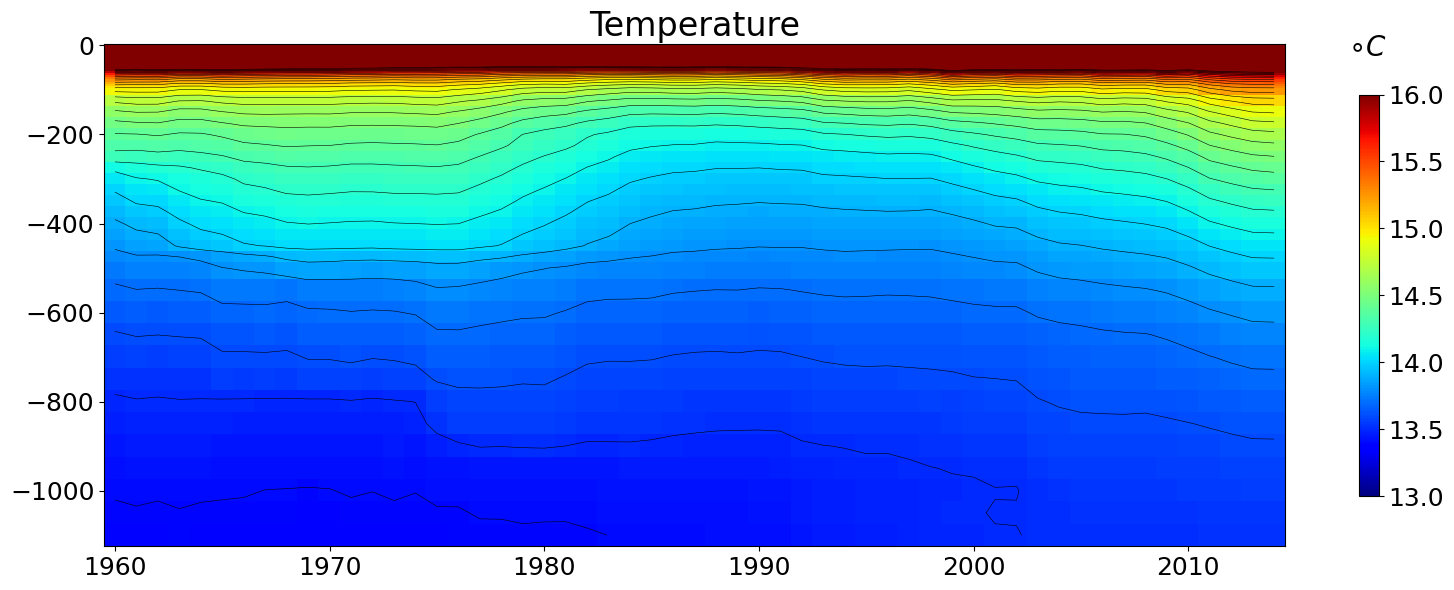

In [21]:
# Debugging: Check if the temperature profile has valid data
print(f"Temperature profile shape: {temperature.shape}")

print(f"Temperature profile min: {np.min(temperature)}")
print(f"Temperature profile max: {np.max(temperature)}")

# Calculate the mean along the first and second dimensions, ignoring NaN values
temperature_profile = np.nanmean(temperature, axis=(0, 1))

# Calculate the mean along the first and second dimensions, ignoring NaN values
#temperature_profile = np.expand_dims(np.nanmean(temperature, axis=(0, 1)), axis=(0, 1))

# Show the size of the temperature profile
print("Size of temperature_profile:", temperature_profile.shape)

# Plotting the temperature profile
plt.figure(figsize=(16, 6))
ax = plt.gca()
ax.tick_params("both", labelsize=16)

# Contour plot for temperature profile
contour_levels = np.arange(13, 16.1, 0.1)  # Define contour levels
contour = ax.contour(years, -depthr, temperature_profile, levels=contour_levels, colors="k", linewidths=0.4)

# Filled contour plot for temperature profile
pcolor = ax.pcolor(years, -depthr, temperature_profile, vmin=13, vmax=16, cmap="jet")

# Add colorbar
colorbar = plt.colorbar(pcolor, orientation="vertical", shrink=0.8)
colorbar.ax.tick_params(labelsize=18)

# Add the label on top of the colorbar
colorbar.set_label('$\circ{C}$\n', fontsize=20, labelpad=-20, loc='top')  # loc='top' positions the label at the top
colorbar.ax.tick_params(labelsize=18)

# Set the label rotation to be horizontal (not rotated)
colorbar.ax.yaxis.set_label_position('left')
colorbar.ax.yaxis.label.set_rotation(0)  # 0 degrees rotation to make it horizontal

# Set title
plt.title("Temperature", fontsize=24)


# Set tick labels size
plt.tick_params(axis='both', which='major', labelsize=18)


plt.tight_layout()
# Save the plot as an image file with specified settings (e.g., resolution)
plt.savefig(OUTPUT_PATH+'TEMP_PROFILE_'+suffix+'.png', bbox_inches='tight', dpi=200)


# Display the plot
plt.show()

### Hoev-Moller Plot for the Average Temperature Anomaly

<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\c'
<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\c'
C:\Users\ousse\AppData\Local\Temp\ipykernel_20608\4102507068.py:29: SyntaxWarning: invalid escape sequence '\c'
  cbar = plt.colorbar(orientation="vertical", shrink=0.8, label = '$\circ{C}$')
C:\Users\ousse\AppData\Local\Temp\ipykernel_20608\4102507068.py:33: SyntaxWarning: invalid escape sequence '\c'
  cbar.set_label('$\circ{C}$\n', fontsize=20, labelpad=-20, loc='top')  # loc='top' positions the label at the top


Shape of temperature: (239, 106, 49, 55)
Shape of temperature_reference_4d: (239, 106, 49, 55)


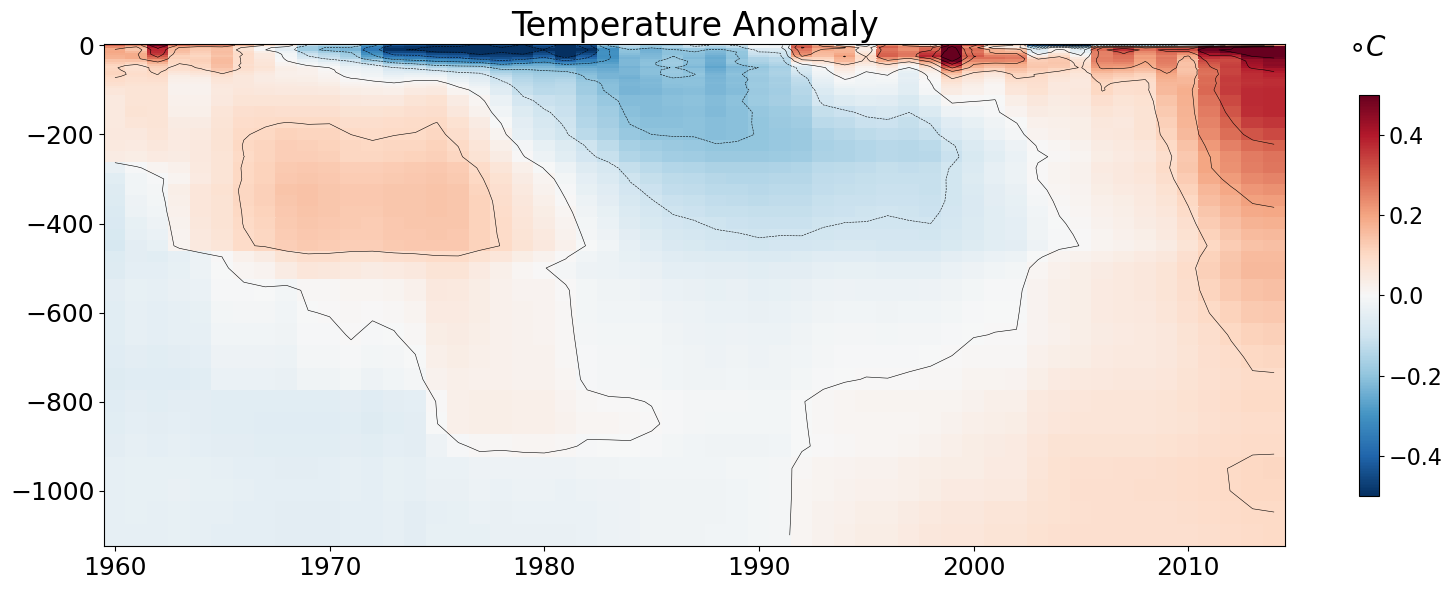

In [22]:
####################################################################################################
# Plotting the average temperature anomaly
####################################################################################################

# Step 1: Expand the reference temperature in the 4th dimension without adding an unnecessary axis
temperature_reference_4d = np.repeat(temperature_reference[:, :, :], temperature.shape[3], axis=3)

# Check the shapes to ensure they match
print("Shape of temperature:", temperature.shape)
print("Shape of temperature_reference_4d:", temperature_reference_4d.shape)

# Step 2: Subtract temperature_reference_4d from temperature
temperature_diff = temperature - temperature_reference_4d

# Step 3: Use np.nanmean to compute the mean across axes 0 and 1
temperature_profile = np.nanmean(temperature_diff, axis=(0, 1))

# Step 4: Plot the results
plt.figure(figsize=(16, 6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=10)

# Create contour and pcolor plots
contour_levels = np.arange(-0.5, 0.6, 0.1)
plt.contour(years, -depthr, temperature_profile, levels=contour_levels, colors='k', linewidths=0.4)
plt.pcolor(years, -depthr, temperature_profile, vmin=-0.5, vmax=0.5, cmap='RdBu_r')

# Add colorbar
cbar = plt.colorbar(orientation="vertical", shrink=0.8, label = '$\circ{C}$')
cbar.ax.tick_params(labelsize=16)

# Add the label on top of the colorbar
cbar.set_label('$\circ{C}$\n', fontsize=20, labelpad=-20, loc='top')  # loc='top' positions the label at the top
cbar.ax.tick_params(labelsize=16)

# Set the label rotation to be horizontal (not rotated)
cbar.ax.yaxis.set_label_position('left')
cbar.ax.yaxis.label.set_rotation(0)  # 0 degrees rotation to make it horizontal


# Add title
plt.title("Temperature Anomaly", fontsize=24)

# Set tick labels size
plt.tick_params(axis='both', which='major', labelsize=18)

plt.tight_layout()
# Save the plot as an image file with specified settings (e.g., resolution)
plt.savefig(OUTPUT_PATH+'TEMP_ANOMALY_'+suffix+'.png', bbox_inches='tight', dpi=200)


# Show the plot
plt.show()

## Define constants

In [23]:
# Constants
reference_density = 1030  # kg m-3
specific_heat_capacity = 3980  # J kg-1 degree_C-1

# Assuming delta_lon, delta_lat, mask, and delta_depth are numpy arrays

# Calculate horizontal area
horizontal_area = delta_lon[:, :, 0] * delta_lat[:, :, 0] * mask[:, :, 0]

# Sum of the non-missing values in horizontal_area
horizontal_area_total = np.nansum(horizontal_area)  # Equivalent to filtering out missing values

print(horizontal_area.shape)
print(horizontal_area_total)

(239, 106)
2018165700000.0


In [24]:
#####################################
# Bottom Depth
bottom_depth = depth_max
print('Bottom Depth ', bottom_depth)

Bottom Depth  1100.0


## Select bottom depth for heat content computation

In [25]:
# Find the index of the bottom depth (the first index where the difference is minimized)
bottom_depth_index = np.argmin(np.abs(depthr - bottom_depth))

# Calculate the total vertical area up to the bottom depth index
vertical_area_total = np.sum(delta_depth[0, 0, :bottom_depth_index+1])
print(bottom_depth_index)
print(vertical_area_total)

48
1125.0


## Computation

In [26]:
# Assuming temperature, temperature_reference, delta_depth, horizontal_area, mask, bottom_depth_index, reference_density, specific_heat_capacity, and horizontal_area_total are numpy arrays

# Repeating arrays along the 4th dimension
# Step 1: Repeat the temperature_reference along the 4th dimension
temperature_reference_4d = np.repeat(temperature_reference[:, :, :], temperature.shape[3], axis=3)

# Display the sizes
print("size(temperature_reference):", temperature_reference.shape)
print("size(temperature_reference_4d):", temperature_reference_4d.shape)


delta_depth_4d = np.repeat(delta_depth[:, :, :, np.newaxis], temperature.shape[3], axis=3)
horizontal_area_4d = np.repeat(np.expand_dims(horizontal_area, axis=2)[:, :, :, np.newaxis], temperature.shape[3], axis=3)

#np.expand_dims(np.nanmean(temperature[:, :, :, time_indices], axis=3), axis=3)

print("size(delta_depth_4d):", delta_depth_4d.shape)
print("size(horizontal_area_4d):", horizontal_area_4d.shape)

size(temperature_reference): (239, 106, 49, 1)
size(temperature_reference_4d): (239, 106, 49, 55)
size(delta_depth_4d): (239, 106, 49, 55)
size(horizontal_area_4d): (239, 106, 1, 55)


In [27]:
# Temperature anomaly calculation
temperature_anomaly = temperature - temperature_reference_4d
print("size(temperature_anomaly):", temperature_anomaly.shape)

# Temperature anomaly integrand
temperature_anomaly_integrand = temperature_anomaly * delta_depth_4d
print("size(temperature_anomaly_integrand):", temperature_anomaly_integrand.shape)

# Replace missing values (NaNs in Python) with 0
temperature_anomaly_integrand = np.nan_to_num(temperature_anomaly_integrand, nan=0)
print("size(temperature_anomaly_integrand):", temperature_anomaly_integrand.shape)

# Sum over the vertical (3rd) dimension

vertical_temperature_anomaly_sum = np.sum(temperature_anomaly_integrand[:, :, :bottom_depth_index + 1, :], axis=2)
#vertical_temperature_anomaly_sum = np.sum(temperature_anomaly_integrand[:, :, :bottom_depth_index, :], axis=2)

print("size(vertical_temperature_anomaly_sum):", vertical_temperature_anomaly_sum.shape)

vertical_temperature_anomaly_sum = np.expand_dims(vertical_temperature_anomaly_sum, axis=2)

# Apply mask to the sum
print("size(vertical_temperature_anomaly_sum):", vertical_temperature_anomaly_sum.shape)

print("size(mask):", mask.shape)

# Add two new axes to make the shapes compatible in Python
masked_array = mask[:, :, 0, np.newaxis, np.newaxis]
vertical_temperature_anomaly_sum *= masked_array
print("size(vertical_temperature_anomaly_sum):", vertical_temperature_anomaly_sum.shape)

# Initialize arrays for temperature anomaly and ocean heat content profiles
temperature_anomaly_profile = np.empty(temperature.shape[3], dtype=np.float64)
print("size(temperature_anomaly_profile_700):", temperature_anomaly_profile.shape)

ocean_heat_content_profile = np.empty(temperature.shape[3], dtype=np.float64)
print("size(ocean_heat_content_profile_700):", ocean_heat_content_profile.shape)

# Loop through each year
for year in range(temperature.shape[3]):
    # Mean temperature anomaly profile up to the bottom depth
    temperature_anomaly_profile[year] = np.nanmean(temperature_anomaly[:, :, :bottom_depth_index + 1, year])
    #temperature_anomaly_profile_700[year] = np.nanmean(temperature_anomaly[:, :, :bottom_depth_index, year])

    # Ocean heat content profile calculation
    ocean_heat_content_profile[year] = (
        reference_density * specific_heat_capacity *
        np.nansum(vertical_temperature_anomaly_sum[:, :, :, year] * horizontal_area_4d[:, :, :, year]) /
        horizontal_area_total
    )
    
print(ocean_heat_content_profile)

size(temperature_anomaly): (239, 106, 49, 55)
size(temperature_anomaly_integrand): (239, 106, 49, 55)


c:\Users\ousse\anaconda3\Lib\site-packages\numpy\ma\core.py:1020: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


size(temperature_anomaly_integrand): (239, 106, 49, 55)
size(vertical_temperature_anomaly_sum): (239, 106, 55)
size(vertical_temperature_anomaly_sum): (239, 106, 1, 55)
size(mask): (239, 106, 49)
size(vertical_temperature_anomaly_sum): (239, 106, 1, 55)
size(temperature_anomaly_profile_700): (55,)
size(ocean_heat_content_profile_700): (55,)
[-4.87037383e+07 -1.44484458e+07  2.04107728e+07 -5.51751759e+06
  1.48697697e+07  7.03244977e+07  8.70767231e+07  8.65012952e+07
  8.92410375e+07  8.58357632e+07  7.52496918e+07  6.31422566e+07
  3.24810836e+07  2.19181453e+07  3.04827453e+07  6.88310187e+07
  5.76571574e+07  1.46869245e+07 -3.87144451e+07 -1.01632753e+08
 -1.25230824e+08 -1.88455010e+08 -2.30779581e+08 -2.38937279e+08
 -2.59077586e+08 -2.73655478e+08 -2.81554672e+08 -2.91182321e+08
 -3.14869730e+08 -3.00004827e+08 -2.77668691e+08 -2.61293283e+08
 -1.75633298e+08 -1.28139810e+08 -1.01027362e+08 -1.11345804e+08
 -7.25216981e+07 -9.33826680e+07 -5.08031626e+07  6.24528183e+07
  2.652

## Plot of Temperature anomaly profile

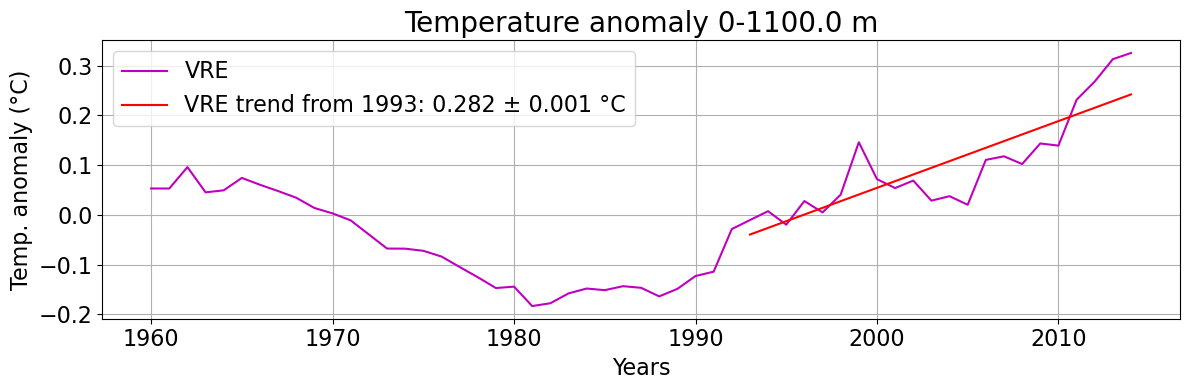

In [28]:
# Assuming years and temperature_anomaly_profile are numpy arrays

plt.figure(figsize=(12, 4))
plt.grid(True)

# Plot the temperature anomaly profile
plt.plot(years, temperature_anomaly_profile, "m-", label="VRE")

# Find the index for the year 1993
year_index = np.argwhere(years == 1993)[0][0]
#year_index = years.index(1993)

# Fit a polynomial (degree 1, i.e., linear) to the data from 1993 onwards
temperature_anomaly_profile_fit = np.polyfit(years[year_index:], temperature_anomaly_profile[year_index:], 1)
fit_function = np.poly1d(temperature_anomaly_profile_fit)

# Calculate the trend from 1993 to 2014
profile_annual_trend = np.round(fit_function(2014) - fit_function(1993), decimals=3)

# Plot the linear fit
plt.plot(years[year_index:], fit_function(years[year_index:]), "r-", 
         label=f"VRE trend from 1993: {profile_annual_trend:.3f} ± 0.001 °C")

# Labels and title
plt.xlabel("Years", fontsize=16)
plt.ylabel("Temp. anomaly (°C)", fontsize=16)
plt.title(f"Temperature anomaly 0-{bottom_depth} m", fontsize=20)
plt.legend(fontsize=16)

# Set tick labels size
plt.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
# Save the plot as an image file with specified settings (e.g., resolution)
plt.savefig(OUTPUT_PATH+'TEMP_ANOMALY_TREND_'+suffix+'.png', bbox_inches='tight', dpi=200)

# Show the plot
plt.show()

## Plot of Ocean Heat Content profile

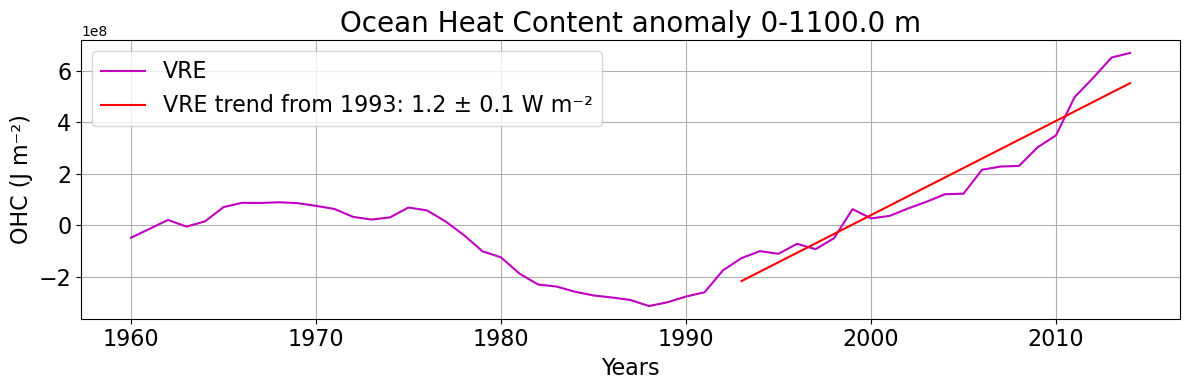

In [29]:
# Assuming years and ocean_heat_content_profile_700 are numpy arrays

plt.figure(figsize=(12, 4))
plt.grid(True)

# Plot the ocean heat content anomaly profile
plt.plot(years, ocean_heat_content_profile, "m-", label="VRE")

# Find the index for the year 1993
year_index = np.where(years == 1993)[0][0]
#year_index = years.index(1993)

# Fit a polynomial (degree 1, i.e., linear) to the data from 1993 onwards
ocean_heat_content_profile_fit = np.polyfit(years[year_index:], ocean_heat_content_profile[year_index:], 1)
fit_function = np.poly1d(ocean_heat_content_profile_fit)

# Calculate the trend from 1993 to the end year
# Divide by (86400 * 365) to convert J/year to W (J/s)
profile_annual_trend = np.round((fit_function(1) - fit_function(0)) / (86400. * 365), decimals=1)

# Plot the linear fit
plt.plot(years[year_index:], fit_function(years[year_index:]), "r-", 
         label=f"VRE trend from 1993: {profile_annual_trend:.1f} ± 0.1 W m⁻²")

# Labels and title
plt.xlabel("Years", fontsize=16)
plt.ylabel("OHC (J m⁻²)", fontsize=16)
plt.title(f"Ocean Heat Content anomaly 0-{bottom_depth} m", fontsize=20)
plt.legend(fontsize=16)

# Set tick labels size
plt.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
# Save the plot as an image file with specified settings (e.g., resolution)
plt.savefig(OUTPUT_PATH+'OHC_700_ANOMALY_'+suffix+'.png', bbox_inches='tight', dpi=200)

# Show the plot
plt.show()

## Write output in netCDF dataset

In [30]:
# 1. Definisci il percorso completo del file di output PRIMA di ogni altra cosa
out_file = os.path.join(OUTPUT_PATH, 'Ocean_Heat_Content_WP4_' + suffix + '.nc')

# 2. Estrai il percorso della cartella da out_file e assicurati che esista
#    Questo è il passaggio chiave che risolve l'errore.
output_directory = os.path.dirname(out_file)
os.makedirs(output_directory, exist_ok=True)

# 3. Ora che la cartella esiste di sicuro, procedi con la cancellazione del file
#    Questo blocco ora funzionerà in modo affidabile.
if os.path.isfile(out_file):
    try:
        os.remove(out_file)
        print(f"Rimozione del file esistente: {out_file}")
    except OSError as e:
        print(f"Errore durante la rimozione del file (potrebbe essere un problema di permessi): {e}")

# 4. Crea il nuovo file NetCDF
print(f"Creazione del nuovo file: {out_file}")
# Create the output dataset
out_data = Dataset(out_file, "w", format="NETCDF4")

# Global attributes
out_data.setncatts({
    "Conventions": "CF-1.6"
})

# Define dimensions
depth_dim = out_data.createDimension("depth", 1)
time_dim = out_data.createDimension("time", len(years))
nv_dim = out_data.createDimension("nv", climatology_bounds.shape[0])

# Define variables
nctime = out_data.createVariable("time", "f8", ("time",))
nctime.units = "days since 1900-01-01 00:00:00"
nctime.standard_name = "time"
nctime.long_name = "time"
nctime.calendar = "standard"
nctime.climatology = "climatology_bounds"

ncdepth_bounds = out_data.createVariable("depth_bounds", "f8", ("nv", "depth"))
ncdepth_bounds.units = "m"

ncclimatology_bounds = out_data.createVariable("climatology_bounds", "f8", ("nv", "time"))
ncclimatology_bounds.units = "days since 1900-01-01 00:00:00"

# Variables for ocean heat content and temperature anomaly, using ("time", "depth") to switch dimensions
ncVariable1 = out_data.createVariable("Ocean_Heat_Content", "f4", ("time", "depth"), fill_value=9.96921e36, zlib=True)
ncVariable1.units = "J"
ncVariable1.standard_name = "ocean_heat_content"
ncVariable1.long_name = "Ocean Heat Content Anomaly"
ncVariable1.cell_methods = "time: mean within years time: mean over years"

ncVariable2 = out_data.createVariable("Temperature_anomaly", "f4", ("time", "depth"), fill_value=9.96921e36, zlib=True)
ncVariable2.units = "degrees_C"
ncVariable2.standard_name = "sea_water_temperature"
ncVariable2.long_name = "Sea Water In Situ Temperature Anomaly"
ncVariable2.cell_methods = "time: mean within years time: mean over years"

# Assigning data to variables (switching order to [time, depth])
ncVariable1[:, 0] = ocean_heat_content_profile  # Assigning time along first axis
ncVariable2[:, 0] = temperature_anomaly_profile  # Assigning time along first axis

# Assign time data
nctime[:] = time

# Close the dataset
out_data.close()

Creazione del nuovo file: blue-cloud-dataspace/MEI/OceanHeatContent/Ocean_Heat_Content_WP4_-1_28_31_44_0_1100.nc
